In [338]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


# 1. Exploratory Data Analysis (EDA)

## Preliminary Information

In [339]:
# Size of the dataset 
import pandas as pd
df = pd.read_csv('./data/flight_data.csv')
rows, cols = df.shape
print("number of rows:", rows)
print("number of cols:", cols)

number of rows: 998866
number of cols: 18


In [340]:
# Data types of columns
col_data_types = df.dtypes
col_data_types_str = col_data_types.to_string()
print(col_data_types_str)

from_airport_code                   object
from_country                        object
dest_airport_code                   object
dest_country                        object
aircraft_type                       object
airline_number                      object
airline_name                        object
flight_number                       object
departure_time                      object
arrival_time                        object
duration                             int64
stops                                int64
price                              float64
currency                            object
co2_emissions                      float64
avg_co2_emission_for_this_route    float64
co2_percentage                      object
scan_date                           object


## Information on target variable
The chosen target variable is the CO2 emissions of a given flight, and it's a continuous variable since it covers a wide spectrum of values.

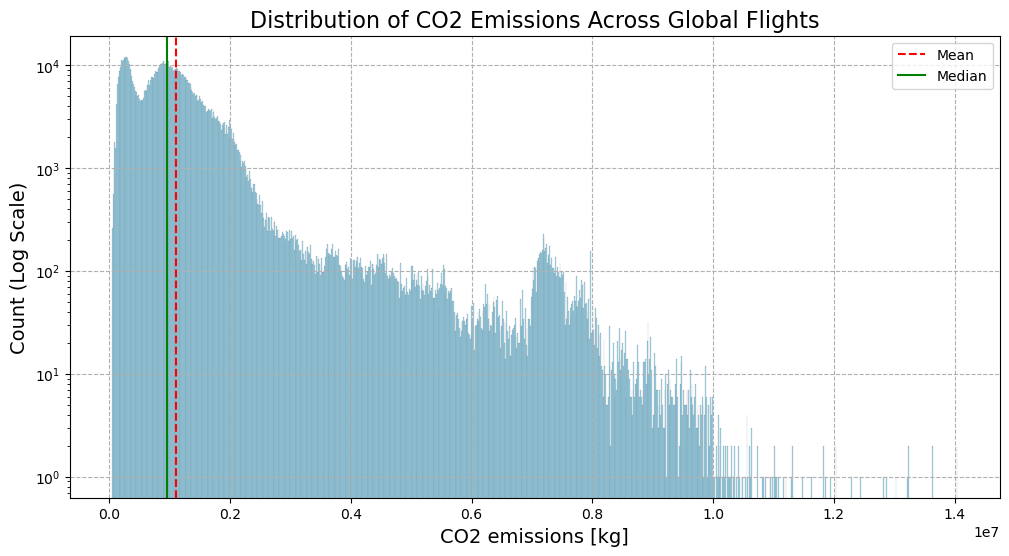

mean: 1111010.421550144
median: 956000.0


In [341]:
# Visualize target variable
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


mean_val = df['co2_emissions'].mean()
median_val = df['co2_emissions'].median()

plt.figure(figsize=(12, 6))

count = int(np.sqrt(df.shape[0]))
sns.histplot(df['co2_emissions'], bins=count, color='skyblue', kde=False)


plt.yscale('log')
plt.axvline(mean_val, color='r', linestyle='--')
plt.axvline(median_val, color='g', linestyle='-')
plt.grid(True, linestyle='--')


plt.xlabel('CO2 emissions [kg]', fontsize=14)
plt.ylabel('Count (Log Scale)', fontsize=14)
plt.title('Distribution of CO2 Emissions Across Global Flights', fontsize=16)
plt.legend({'Mean': mean_val, 'Median': median_val})

plt.show()
print("mean:", mean_val)
print("median:", median_val)

## More Visualizations & Insights
First, I'm going to look at which (continuous?) variables correlate the most with the target variable by using a correlation matrix. 

In [342]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_with_target = corr_matrix['co2_emissions'].sort_values(key=abs, ascending=False)
corr_with_target = corr_with_target.drop('co2_emissions')
corr_with_target = corr_with_target.drop('avg_co2_emission_for_this_route')
print(corr_with_target.head(5))

price       0.724647
duration    0.492424
stops       0.377681
Name: co2_emissions, dtype: float64


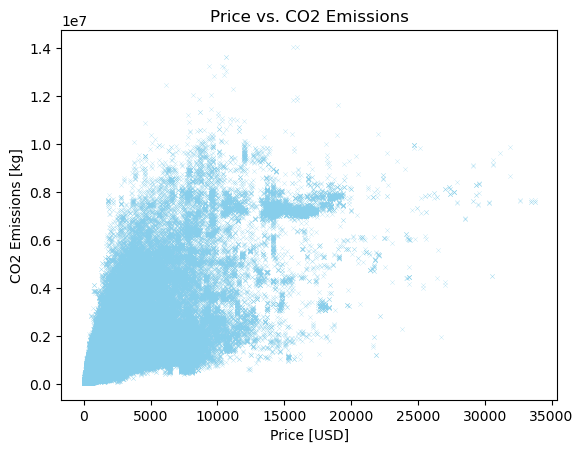

In [343]:
# Continuous variable that correlates with CO2 emissions: price.
plt.figure()
sns.scatterplot(data=df, x='price', y='co2_emissions', marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Price vs. CO2 Emissions')
plt.xlabel('Price [USD]')
plt.ylabel('CO2 Emissions [kg]')

plt.show()

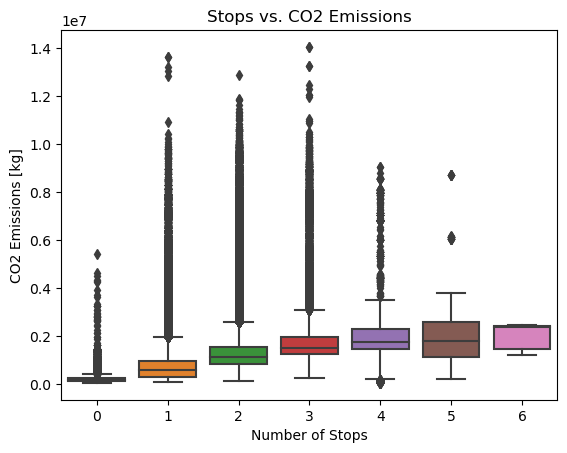

In [344]:
# Ordinal variable that correlates with CO2_emissions: stops
plt.figure()
sns.boxplot(data=df, x='stops', y='co2_emissions')

plt.title('Stops vs. CO2 Emissions')
plt.xlabel('Number of Stops')
plt.ylabel('CO2 Emissions [kg]')
plt.show()

The box plot above suggests that flights with more stops will tend to have higher emissions. This also is confirmed with the correlation coefficient that we've seen above, of approximately 0.378. The heights of the boxes show that flights with 3+ stops have a wider range of CO2 emissions compared to flights with fewer stops - could be attributed to distance, passenger load, or the type of aircraft. Furthermore, the median line shifts upwards as the number of stops increases, which confirms the hypothesis that more stops generally correlate with higher emissions. The points outside the whiskers, the outliers, are especially abundant, which could point to the fact that this variable alone isn't enough to explain the variation in emissions. There are most likely other variables (that I mentioned) that contribute to the emissions.

In [345]:
# Categorical variable that correlates with CO2_emissions: aircraft
# Since there are too many aircrafts, we'll go with the top 10 frequent
aircraft_type_counts = df['aircraft_type'].value_counts()
top_10 = aircraft_type_counts.nlargest(10).index
filtered_df = df[df['aircraft_type'].isin(top_10)]
print(top_10, aircraft_type_counts.nlargest(10))

Index(['Airbus A320|Airbus A320', 'Boeing 737|Boeing 737',
       'Boeing 777|Boeing 777', 'Airbus A320|Boeing 777',
       'Airbus A321|Airbus A321', 'Airbus A321|Airbus A320',
       'Airbus A319|Airbus A320', 'Airbus A320|Boeing 787',
       'Airbus A320|Airbus A321', 'Airbus A320|Airbus A319'],
      dtype='object', name='aircraft_type') aircraft_type
Airbus A320|Airbus A320    22055
Boeing 737|Boeing 737      14777
Boeing 777|Boeing 777       7344
Airbus A320|Boeing 777      7150
Airbus A321|Airbus A321     6057
Airbus A321|Airbus A320     5929
Airbus A319|Airbus A320     5922
Airbus A320|Boeing 787      5670
Airbus A320|Airbus A321     5393
Airbus A320|Airbus A319     5201
Name: count, dtype: int64


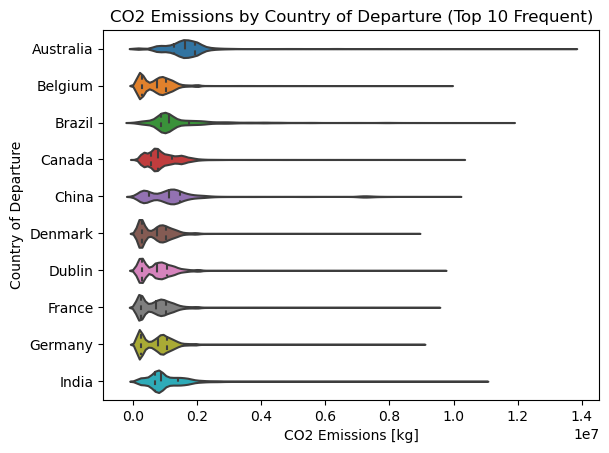

In [346]:
# Categorical variable: `from_country`
country_counts = df['from_country'].value_counts()
top_10 = country_counts.nlargest(10).index
filtered_df = df[df['from_country'].isin(top_10)]

plt.figure()
sns.violinplot(x='co2_emissions', y='from_country', data=filtered_df, inner='quartile')
plt.title('CO2 Emissions by Country of Departure (Top 10 Frequent)')
plt.xlabel('CO2 Emissions [kg]')
plt.ylabel('Country of Departure')
plt.show()

Since the width of the violin indicates the density of data points at that level, we can see that Australia has the highest CO2 emissions among all the countries that appear the most frequently in the dataset. The long "tail" for the violins observed could be due to multiple-leg flights, longer flights, or usage of aircraft with higher emissions. 

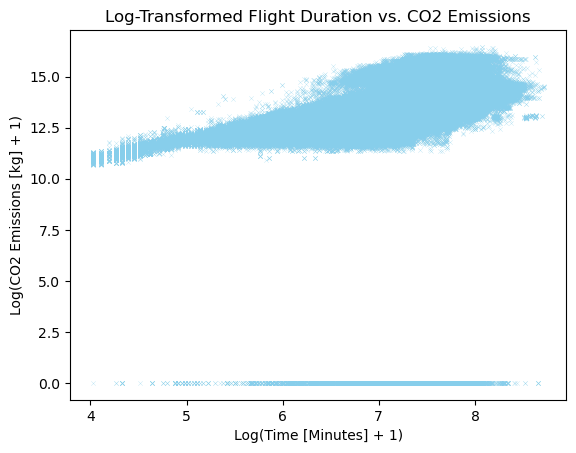

In [347]:
# Continuous variable: duration
log_duration = np.log1p(df['duration'])
log_co2_emissions = np.log1p(df['co2_emissions'].fillna(0))

plt.figure()
sns.scatterplot(x=log_duration, y=log_co2_emissions, marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Log-Transformed Flight Duration vs. CO2 Emissions')
plt.xlabel('Log(Time [Minutes] + 1)')
plt.ylabel('Log(CO2 Emissions [kg] + 1)')
plt.show()

**Note!**
Since dropping rows is a part of EDA and I have decided previously (when splitting on `aircraft_type` for the midterm checkpoint) that solely looking at single-leg flights would be the optimal approach, I have elected to drop the rows that contain multi-leg flights from my dataset. This is because it is not possible to obtain precise per-leg information based on aircrafts. As can be seen from the entries above, the flights in the dataset involve multiple legs operated by different aircraft types, so it would be difficult to specifically isolate a specific aircraft to visualize against CO2 emissions.

In [348]:
# Now we can drop the rows and find the total number of single leg flights
def count_aircraft_types(cell):
    # for empty rows, we make them 0 for now
    return cell.count('|') if isinstance(cell, str) else 0

aircraft_counts = df['aircraft_type'].apply(count_aircraft_types)
df_single_aircraft = df[aircraft_counts == 0]
remaining_rows = len(df_single_aircraft)
print('The number of remaining rows in this new dataframe:', remaining_rows)

# reassign the variable df to our new filtered df_single_aircraft for simplicity
df = df_single_aircraft
print(df.head())

The number of remaining rows in this new dataframe: 30837
     from_airport_code from_country dest_airport_code dest_country  \
1113               ALG      Algeria               VIE      Austria   
1383               ALG      Algeria               VIE      Austria   
3002               ALG      Algeria               DUB       Dublin   
3155               ALG      Algeria               DUB       Dublin   
3156               ALG      Algeria               DUB       Dublin   

     aircraft_type airline_number airline_name  flight_number  \
1113           NaN             TO  [Transavia]  TO7261|TO7261   
1383           NaN             TO  [Transavia]  TO7265|TO7265   
3002           NaN             TO  [Transavia]  TO7261|TO7261   
3155           NaN             TO  [Transavia]  TO7265|TO7265   
3156           NaN             TO  [Transavia]  TO7265|TO7265   

           departure_time         arrival_time  duration  stops  price  \
1113  2022-05-02 08:30:00  2022-05-02 17:45:00       495

# 2. Splitting the Dataset

## Consideration of iid/non-iid dataset
First we need to consider whether this dataset is iid. I believe this dataset is non-iid because it has time-based attributes like `departure_time` -- flights that are closer in time might be more similar to each other. Similarity can also be geographical, since flights leaving from the same airports might share characteristics. Most obviously, I expect groups like `price` and `duration` to be correlated. 

Now that we've established that it's non iid, I am deciding to split on Group ID instead of time series data for the following reasons. The non-iid nature of the data most likely comes more from operational dependencies (like similar emissions from the same airline, aircraft type, departure country) rather than temporal factors. Though it's true that there are more flights during the summer season or during specific times, the dataset is global and includes numerous entries from different timezones/hemispheres/seasons, which could eventually balance this problem out. 

In [349]:
## Splitting
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

df['aircraft_type'].fillna('Unknown', inplace=True)
# drop columns that are closely related to the target variable
df.drop(columns=['co2_percentage'], inplace=True)
df.drop(columns=['avg_co2_emission_for_this_route'], inplace=True)
# since all flights in dataset are now single-leg, the stops feature is now redundant
df.drop(columns=['stops'], inplace=True)
# since all currency in dataset is in USD, this feature is also redundant
df.drop(columns=['currency'], inplace=True)

y = df['co2_emissions']
df.drop(columns=['co2_emissions'],inplace=True)
X = df
groups = df['aircraft_type']

splitter = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

train_indices = []
test_indices = []

# first split - 20% to test, 80% to other
for train_idx, test_idx in splitter.split(X,y,groups):
    X_other, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_other, y_test = y.iloc[train_idx], y.iloc[test_idx]
    groups_other = groups.iloc[train_idx]

# second split - 60% training, 20% validation
X_train, X_CV, y_train, y_CV, groups_train, groups_CV = train_test_split(\
    X_other, y_other, groups_other, train_size=0.75, random_state=42)

print(len(X_train), len(X_CV), len(X_test))
print(df.shape)
print(X_train.head())

18453 6151 6233
(30837, 13)
       from_airport_code from_country dest_airport_code    dest_country  \
821453               FRA      Germany               OSL          Norway   
380755               SCL        Chile               LIM            Peru   
891562               ATH       Greece               CPH         Denmark   
305063               YYZ       Canada               DUB          Dublin   
958048               DEL        India               MAN  United Kingdom   

       aircraft_type airline_number                     airline_name  \
821453       Unknown          multi                 [LOT| Norwegian]   
380755   Airbus A320             JA                       [jetSMART]   
891562       Unknown          multi                 [SAS| Norwegian]   
305063       Unknown          multi        [Air Transat| Aer Lingus]   
958048       Unknown          multi  [SpiceJet| Jazeera| SunExpress]   

                  flight_number       departure_time         arrival_time  \
821453     

## Overall Stats

In [350]:
group_sizes = df['aircraft_type'].value_counts()
stats = {
    "total groups": len(group_sizes),
    "min group size": group_sizes.min(),
    "max group size": group_sizes.max(),
    "mean group size": group_sizes.mean(),
    "median group size": group_sizes.median()
}
print(stats)

{'total groups': 37, 'min group size': 3, 'max group size': 13914, 'mean group size': 833.4324324324324, 'median group size': 124.0}


# 3. Preprocessing

In [351]:
# collect the various features - notice we don't have ordinal features anymore
cat_ftrs = ['from_airport_code', 'from_country', 'dest_airport_code', 'dest_country', 'aircraft_type'\
           , 'airline_number', 'airline_name', 'flight_number']
num_ftrs = ['departure_time', 'arrival_time', 'duration', 'price', 'scan_date']

# first, need to convert timestamps to float
def convert_timestamps(df, timestamp_columns):
    '''
    converts each timestamp to a total number of minutes since midnight
    '''
    for col in timestamp_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d %H:%M:%S')
            converted_col_name = col + '_converted'
            df[converted_col_name] = df[col].dt.hour * 60 + df[col].dt.minute
            df[col] = df[converted_col_name]
            df.drop(columns=[converted_col_name], inplace=True)
    return df

timestamp_columns = ['departure_time', 'arrival_time', 'scan_date']

X_train = convert_timestamps(X_train.copy(), timestamp_columns)
X_CV = convert_timestamps(X_CV.copy(), timestamp_columns)
X_test = convert_timestamps(X_test.copy(), timestamp_columns)

In [352]:
# now, preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='Unknown')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

# fit_transform 
X_train_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out() # Collect feature names

df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV, columns=feature_names)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test, columns=feature_names)

print(df_train.shape)
print(df_CV.shape)
print(df_test.shape)

(18453, 8128)
(6151, 8128)
(6233, 8128)


In [353]:
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (18453, 8128)
fraction of missing values in features:
num__price    0.021406
dtype: float64
fraction of points with missing values: 0.021405733485070178


## Handling continuous features
According to the above output, we don't have missing values in ordinal features, so all we have to do is take care of the missing values in `price.` This feature has a relatively low percentage of missing values, which is unlikely to have a big effect.

According to what was covered in lecture, I will cover these three methods in preprocessing, then decide on which approach is the best for my data. For multivariate imputation, I will prepare `n` different imputations and run `n` models on them. For `XGB`, I will run `n` XGB models `n` with different seeds. Finally, for `reduced-features`, I will run `n` reduced-features models with `n` different seed. Then, I will rank the 3 methods based on how significantly different the corresponding mean scores are.

In [ ]:
# Apply multivariate imputation 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

n_imputations = 5
imputed_datasets = []

for i in range(n_imputations):
    imputer = IterativeImputer(estimator=LinearRegression(), random_state=i)
    X_train_impute = imputer.fit_transform(df_train)
    df_train_imp = pd.DataFrame(data=X_train_impute, columns=df_train.columns)

    df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns=df_train.columns)
    imputed_datasets.append((df_train_imp, df_CV_imp))

In [ ]:
# Apply XGBoost

In [ ]:
# Apply reduced pattern submodel

In [ ]:
# Decide which model is best. 

# 4. Choosing Evaluation Metric

# 5. Choosing ML Techniques

# 6. Cross-Validation

# 7. Interpreting